# Import Libraries

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import xgboost as xgb
from xgboost import plot_importance as xgb_plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor

In [ ]:
df_clean = pd.read_csv('df_clean.csv')

In [ ]:
df_clean

,datetime,mileage_km,speed_km_h,elevation_m,fuel_volume_lit,gross_vehicle_weight_kg,distance_covered_km,cumulative_distance_covered,smoothed_fuel,linear_interp,poly_interp,poly_interp_clipped,speed_m_s,speed_diff,time_diff,acceleration,elev_diff
0,2022-06-01 00:00:18,284286.020,0,318,254.31,NaN,0.0,0.000,254.310000,NaN,-7.642412e+09,NaN,0.0,NaN,NaN,0.0,NaN
1,2022-06-01 00:00:30,284286.020,0,318,252.17,NaN,0.0,0.000,253.240000,NaN,-7.629790e+09,NaN,0.0,0.0,12.0,0.0,0.0
2,2022-06-01 00:01:02,284286.020,0,318,252.87,NaN,0.0,0.000,253.116667,NaN,-7.617179e+09,NaN,0.0,0.0,32.0,0.0,0.0
3,2022-06-01 00:02:00,284286.020,0,318,253.94,NaN,0.0,0.000,253.322500,NaN,-7.604578e+09,NaN,0.0,0.0,58.0,0.0,0.0
4,2022-06-01 00:03:30,284286.020,0,318,252.49,NaN,0.0,0.000,253.156000,NaN,-7.591988e+09,NaN,0.0,0.0,90.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49014,2022-06-30 23:53:44,294122.475,0,324,245.38,NaN,0.0,9836.455,245.738667,23600.0,2.161561e+04,21615.611447,0.0,0.0,90.0,0.0,0.0
49015,2022-06-30 23:55:14,294122.475,0,324,245.01,NaN,0.0,9836.455,245.642667,23600.0,2.159757e+04,21597.571551,0.0,0.0,90.0,0.0,0.0
49016,2022-06-30 23:56:44,294122.475,0,323,245.70,NaN,0.0,9836.455,245.642667,23600.0,2.157945e+04,21579.450027,0.0,0.0,90.0,0.0,-1.0
49017,2022-06-30 23:58:14,294122.475,0,322,245.38,NaN,0.0,9836.455,245.642667,23600.0,2.156125e+04,21561.246874,0.0,0.0,90.0,0.0,-1.0


# Dwell Times

In [ ]:
df = df_clean
dwell_times = []
cumulative_dwell_list = []
current_dwell = pd.Timedelta(0)
cumulative_dwell = pd.Timedelta(0)
in_dwell = False
df['datetime'] = pd.to_datetime(df['datetime'])

for i in range(0, len(df)):
    if df.loc[i, 'speed_km_h'] == 0:  # Vehicle is stationary
        if not in_dwell:
            # Start a new stop
            in_dwell = True
            start_time = df.loc[i, 'datetime']
            cumulative_dwell_list.append(current_dwell)
        else:
            current_dwell = df.loc[i, 'datetime'] - start_time
            cumulative_dwell_list.append(current_dwell)

    else:  # Vehicle is moving
        if in_dwell:
            # End the stop and store the dwell time
            dwell_times.append(current_dwell)
            in_dwell = False
            current_dwell = pd.Timedelta(0)  # Reset the dwell time
        cumulative_dwell_list.append(current_dwell)

# If the last timestamp was part of a stop, add its dwell time
if in_dwell:
    dwell_times.append(current_dwell)

# (in minutes)
dwell_times_in_minutes = [dw.total_seconds() / 60 for dw in dwell_times]
print("Dwell times for each stop (in minutes):", dwell_times_in_minutes)
df['cumulative_dwell']=cumulative_dwell_list

Dwell times for each stop (in minutes): [1799.3333333333333, 27.533333333333335, 0.0, 0.25, 13.9, 0.016666666666666666, 0.21666666666666667, 0.016666666666666666, 0.38333333333333336, 0.016666666666666666, 0.016666666666666666, 0.15, 0.65, 0.016666666666666666, 5.0, 0.0, 1.1666666666666667, 0.06666666666666667, 33.86666666666667, 0.25, 21.933333333333334, 1.2166666666666666, 9.966666666666667, 34.583333333333336, 2.7333333333333334, 10.433333333333334, 0.016666666666666666, 0.016666666666666666, 0.016666666666666666, 0.11666666666666667, 0.016666666666666666, 31.016666666666666, 0.15, 0.016666666666666666, 0.016666666666666666, 0.2, 0.2, 0.03333333333333333, 0.05, 754.95, 0.21666666666666667, 2.4, 19.883333333333333, 0.08333333333333333, 57.833333333333336, 0.08333333333333333, 0.0, 0.016666666666666666, 1.0166666666666666, 0.0, 0.0, 48.43333333333333, 0.38333333333333336, 0.016666666666666666, 0.016666666666666666, 0.4, 0.21666666666666667, 0.03333333333333333, 0.48333333333333334, 0.

In [ ]:
filtered_dwell_times = [dt for dt in dwell_times_in_minutes if dt > 0]
len(filtered_dwell_times)

819

In [ ]:
mean_dwell = np.mean(filtered_dwell_times )
median_dwell = np.median(filtered_dwell_times)
min_dwell = np.min(filtered_dwell_times)
max_dwell = np.max(filtered_dwell_times)

print(f"Mean dwell time: {mean_dwell:.2f} minutes")
print(f"Median dwell time: {median_dwell:.2f} minutes")
print(f"Min dwell time: {min_dwell:.2f} minutes")
print(f"Max dwell time: {max_dwell:.2f} minutes")

Mean dwell time: 41.07 minutes
Median dwell time: 0.58 minutes
Min dwell time: 0.02 minutes
Max dwell time: 3803.93 minutes


## Plot dwell times

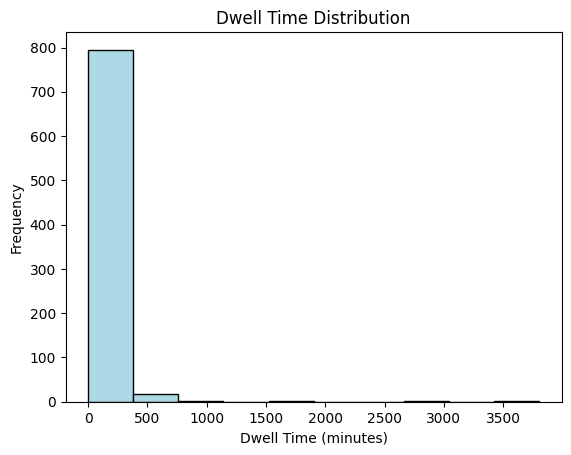

In [ ]:
plt.hist(filtered_dwell_times, edgecolor='black', color='lightblue')
plt.title('Dwell Time Distribution')
plt.xlabel('Dwell Time (minutes)')
plt.ylabel('Frequency')
plt.show()

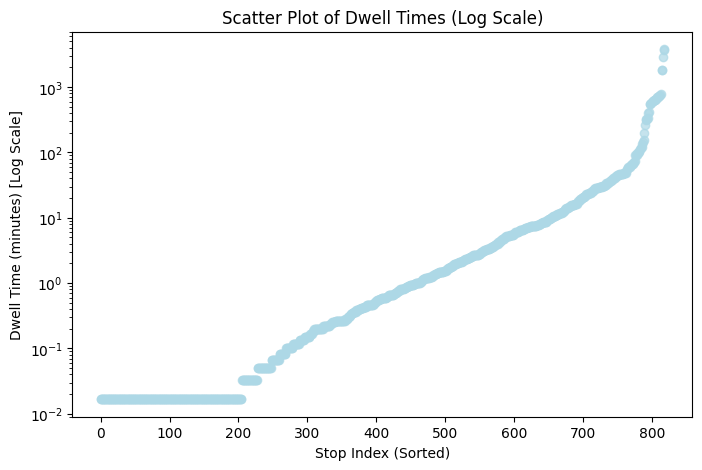

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(range(len(filtered_dwell_times)), np.sort(filtered_dwell_times), alpha=0.7, color='lightblue')
plt.yscale('log')  # Log scale to better see variations
plt.xlabel("Stop Index (Sorted)")
plt.ylabel("Dwell Time (minutes) [Log Scale]")
plt.title("Scatter Plot of Dwell Times (Log Scale)")
plt.show()

## Distribution of dwell times

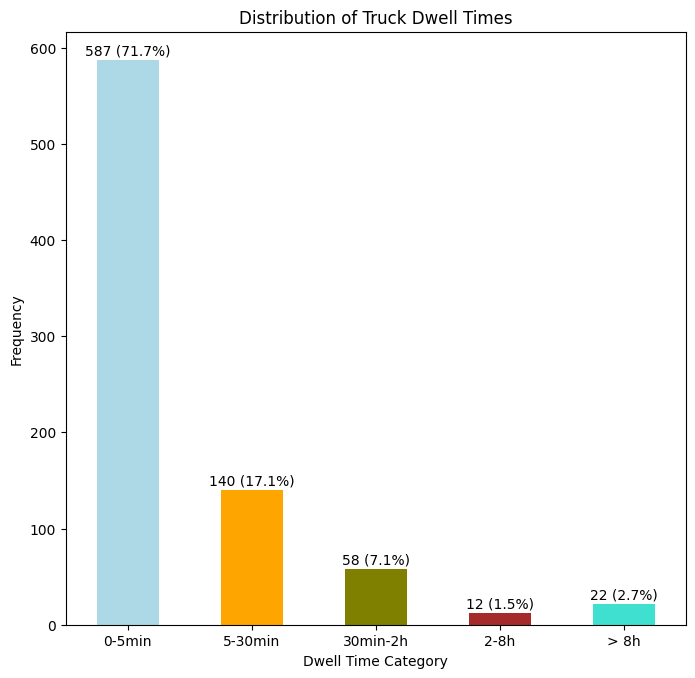

In [ ]:
bins = [0, 5, 30, 120, 480, float("inf")]
labels = ["0-5min", "5-30min", "30min-2h", "2-8h", "> 8h"]

# Categorize dwell times
categories = pd.cut(filtered_dwell_times, bins=bins, labels=labels, right=False)

# Count occurrences in each category
category_counts = categories.value_counts().sort_index()

# Plot bar chart with counts and percentages
plt.figure(figsize=(8, 7.7))
category_counts.plot(kind="bar", color=["lightblue", "orange", "olive", "brown", "turquoise"])
# category_counts.plot(kind="bar", colormap='berlin')
plt.xlabel("Dwell Time Category")
plt.ylabel("Frequency")
plt.title("Distribution of Truck Dwell Times")
plt.xticks(rotation=0)

total = category_counts.sum()
percentages = category_counts / total * 100

for i, (v, p) in enumerate(zip(category_counts, percentages)):
    plt.text(i, v + 5, f"{v} ({p:.1f}%)", ha="center", fontsize=10)

plt.show()

# Trip segmentation (given a time threshold for now)

In [ ]:
def segmentTrips(data, dwell_time_threshold):
    data = data.copy()
    data['trip_id'] = None

    # Variable to track current trip and whether the truck is moving or stopped
    trip_id = 0
    in_trip = False
    current_dwell = pd.Timedelta(0)

    for i in range(0, len(data)):
        if data.loc[i, 'speed_km_h'] == 0:
            cumulative_dwell = data.loc[i,'cumulative_dwell'].total_seconds() / 60
            if cumulative_dwell >= dwell_time_threshold:
                # Mark stop as ending the trip
                data.loc[i, 'trip_id'] = None
                in_trip = False
            else:
                if in_trip:
                    # Start a new trip if the truck wasn't already in one
                    data.loc[i, 'trip_id'] = trip_id
                else:
                    data.loc[i, 'trip_id'] = None
        else:
            if not in_trip:
                trip_id += 1  # New trip starts when the truck moves again
                in_trip = True
            data.loc[i, 'trip_id'] = trip_id

    return data

In [ ]:
df_30_min = segmentTrips(df,30)
df_30_min.to_csv('30min-idle.csv', index=False)
df_2_hours = segmentTrips(df,120)
df_2_hours.to_csv('2hour-idle.csv', index=False)

In [ ]:
def detect_refueling(trip_data, refuel_threshold=100):
    fuel_diff = trip_data['fuel_volume_lit'].diff().fillna(0)
    refuel_indices = fuel_diff[fuel_diff > refuel_threshold].index.tolist()

    refueled_fuel = 0
    if refuel_indices:
        for idx in refuel_indices:
            fuel_before = trip_data.loc[idx - 1, 'fuel_volume_lit'] if idx > 0 else 0
            fuel_after = trip_data.loc[idx, 'fuel_volume_lit']

            fuel_added = fuel_after - fuel_before
            refueled_fuel += fuel_added

    return refueled_fuel

In [ ]:
def calculate_trip_metrics(df):
    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
    df_filtered = df[df['speed_km_h'] > 0].copy()
    df_filtered = df_filtered.reset_index(drop=True)

    grouped_trips = (
        df_filtered.groupby('trip_id')
          .agg(
              start_time=('datetime', 'min'),
              end_time=('datetime', 'max'),
              duration_min=('datetime', lambda x: (x.max() - x.min()).total_seconds() / 60),
              start_fuel=('smoothed_fuel', 'first'),
              end_fuel=('smoothed_fuel', 'last'),
              mean_speed=('speed_km_h', 'mean'),
              mean_acceleration=('acceleration', 'mean'),
              max_acceleration = ('acceleration', 'max'),
              mean_weight=('linear_interp', 'mean'),
              elev_gain=('elev_diff', lambda x: x[x > 0].sum()),
              distance_travelled=('mileage_km', lambda x: x.max() - x.min()),
          )
          .reset_index()
    )

    grouped_trips['refueled_fuel_lit'] = grouped_trips['trip_id'].apply(
        lambda x: detect_refueling(df_filtered[df_filtered['trip_id'] == x])
    )
    grouped_trips['fuel_used_lit'] = grouped_trips['start_fuel'] - grouped_trips['end_fuel']

    grouped_trips['total_fuel_used_lit'] = grouped_trips['fuel_used_lit'] + grouped_trips['refueled_fuel_lit']

    return grouped_trips

In [ ]:
trips_30min_idle = calculate_trip_metrics(df_30_min)
trips_2hours_idle = calculate_trip_metrics(df_2_hours)

In [ ]:
def create_lit_per_100km_column(trips):
    trips['lit_per_100km'] = 100* trips['total_fuel_used_lit'] / trips['distance_travelled']
    return trips
trips_30min_idle = create_lit_per_100km_column(trips_30min_idle)
trips_2hours_idle = create_lit_per_100km_column(trips_2hours_idle)

In [ ]:
def create_valid_trips(trips):
    valid_trips = trips[
        (trips['distance_travelled'] >=5) &
        (trips['lit_per_100km'] >= 3) &
        (trips['lit_per_100km'] <= 80)
    ]
    return valid_trips

valid_30min_trips = create_valid_trips(trips_30min_idle)
valid_2hours_trips = create_valid_trips(trips_2hours_idle)

In [ ]:
def remove_duplicates(all_trips):
    all_trips['is_duplicate'] = all_trips.duplicated(subset=['start_time', 'end_time'], keep='first')
    print(f"Number of duplicates: {all_trips['is_duplicate'].sum()}")
    print(f"Number of unique trips: {len(all_trips) - all_trips['is_duplicate'].sum()}")

    all_trips = all_trips[~all_trips['is_duplicate']]

    all_trips = all_trips.sort_values(by='start_time', ascending=True)
    all_trips.to_csv('all_trips.csv', index=False)
    print(f"{all_trips.shape[0]}")
    return all_trips


In [ ]:
columns_to_drop = ['start_time','end_time','start_fuel','end_fuel',
                   'refueled_fuel_lit','fuel_used_lit']

valid_30min_trips['source'] = '30min'
valid_2hours_trips['source'] = '2hr'
all_trips = pd.concat([valid_30min_trips,valid_2hours_trips], ignore_index=True)
all_trips = remove_duplicates(all_trips)
valid_30min_trips = valid_30min_trips.drop(columns=columns_to_drop)
valid_2hours_trips = valid_2hours_trips.drop(columns=columns_to_drop)
all_trips = all_trips.drop(columns=columns_to_drop)

all_trips.to_csv('all_trips.csv', index=False)
valid_30min_trips.to_csv('trips_30min_idle.csv', index=False)
valid_2hours_trips.to_csv('trips_2hours_idle.csv', index=False)

valid_30min_trips.shape[0],valid_2hours_trips.shape[0],all_trips.shape[0]

Number of duplicates: 1
Number of unique trips: 89
89


<ipython-input-90-b450d3645c7a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_30min_trips['source'] = '30min'
<ipython-input-90-b450d3645c7a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_2hours_trips['source'] = '2hr'


(66, 24, 89)

In [ ]:
def plot_feature_distribution(trips, feature, color, title=None,cap_value=None):
    if title is None:
        title = f'Distribution of {feature}'
    if cap_value is not None:
        trips[feature] = np.minimum(trips[feature], cap_value)
    plt.figure(figsize=(5, 3))
    plt.hist(trips[feature], color=color, edgecolor='white')
    plt.title(title)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    # plt.grid(True)
    plt.show()

In [ ]:
def plot_multiple_boxplots(trips_list, feature, colors, labels, title=None):
    plt.figure(figsize=(10, 6))

    data = [trips[feature] for trips in trips_list]
    boxplot = plt.boxplot(data, patch_artist=True,
                          boxprops=dict(color='gray'),
                          whiskerprops=dict(color='gray'),
                          flierprops=dict(markerfacecolor='red', marker='o', markersize=6))
    for patch, color in zip(boxplot['boxes'], colors):
        patch.set_facecolor(color)

    plt.title(title)
    plt.ylabel(feature)
    plt.xticks(range(1, len(labels) + 1), labels)
    plt.grid(True)
    plt.show()

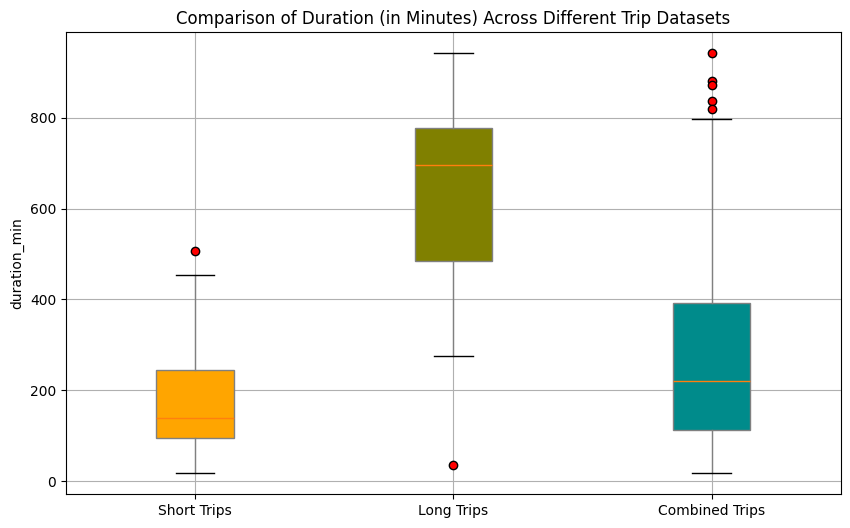

In [ ]:
plot_multiple_boxplots(
    trips_list=[valid_30min_trips, valid_2hours_trips, all_trips],
    feature='duration_min',
    colors = ['orange', 'olive', 'darkcyan'],
    labels = ['Short Trips', 'Long Trips', 'Combined Trips'],
    title='Comparison of Duration (in Minutes) Across Different Trip Datasets'
)

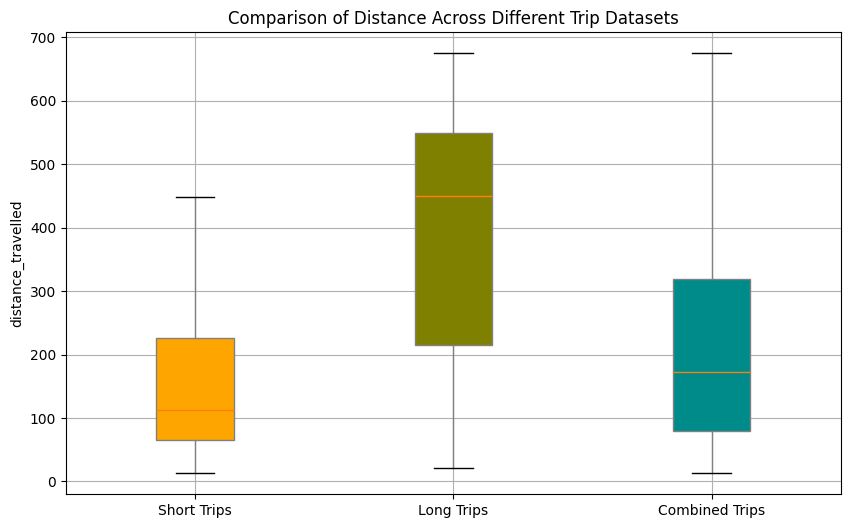

In [ ]:
plot_multiple_boxplots(
    trips_list=[valid_30min_trips, valid_2hours_trips, all_trips],
    feature='distance_travelled',
    colors = ['orange', 'olive', 'darkcyan'],
    labels = ['Short Trips', 'Long Trips', 'Combined Trips'],
    title='Comparison of Distance Across Different Trip Datasets'
)

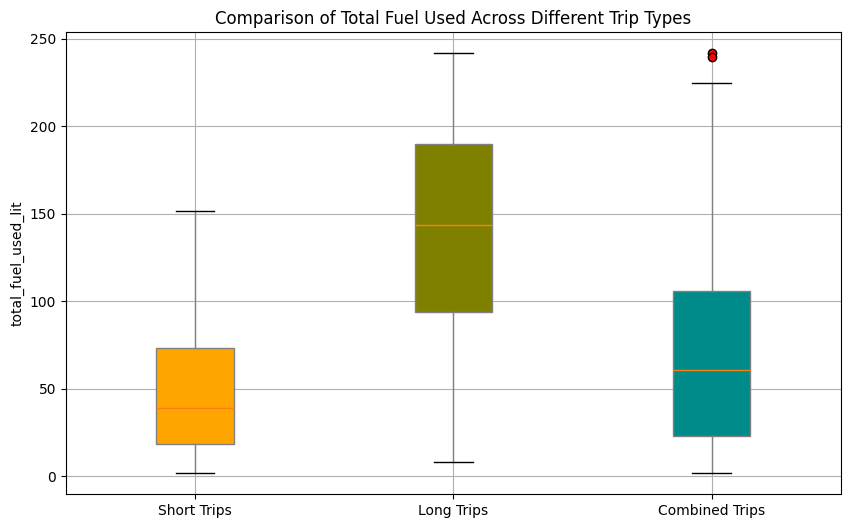

In [ ]:
plot_multiple_boxplots(
    trips_list=[valid_30min_trips, valid_2hours_trips, all_trips],
    feature='total_fuel_used_lit',
    colors = ['orange', 'olive', 'darkcyan'],
    labels = ['Short Trips', 'Long Trips', 'Combined Trips'],
    title='Comparison of Total Fuel Used Across Different Trip Types'
)

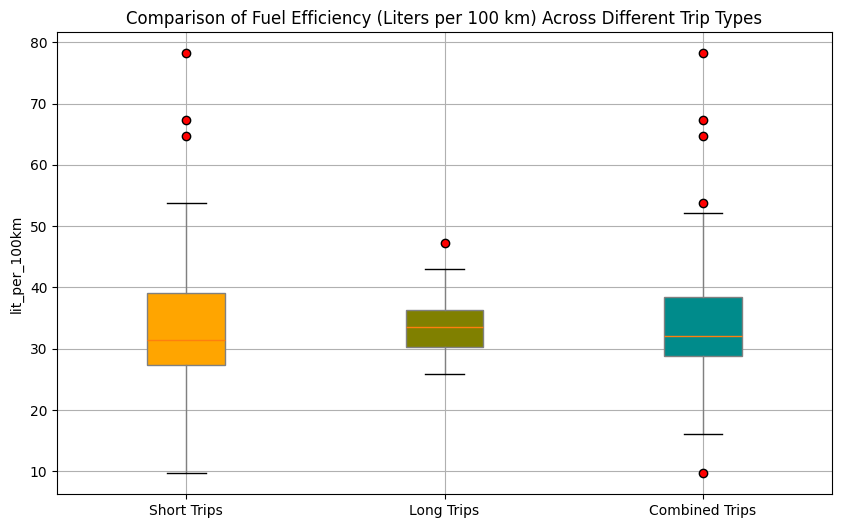

In [ ]:
plot_multiple_boxplots(
    trips_list=[valid_30min_trips, valid_2hours_trips, all_trips],
    feature='lit_per_100km',
    colors = ['orange', 'olive', 'darkcyan'],
    labels = ['Short Trips', 'Long Trips', 'Combined Trips'],
    title='Comparison of Fuel Efficiency (Liters per 100 km) Across Different Trip Types'
)